## Refs
* Dataset: https://physionet.org/content/mitdb/1.0.0/
* Annotation symbols: https://archive.physionet.org/physiobank/annotations.shtml

TODOs:
* Patient level train val test for both 1D and 2D

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb

In [2]:
ROOT_DIR = os.path.abspath("../")
DATA_PATH = os.path.join(ROOT_DIR, "datasets", "mit-bih-arrhythmia-database-1.0.0/")
DATA_PATH

'/home/hasib/ecg-heart/datasets/mit-bih-arrhythmia-database-1.0.0/'

In [3]:
# list of patients
pts = ['100','101','102','103','104','105','106','107',
       '108','109','111','112','113','114','115','116',
       '117','118','119','121','122','123','124','200',
       '201','202','203','205','207','208','209','210',
       '212','213','214','215','217','219','220','221',
       '222','223','228','230','231','232','233','234']

In [4]:
len(pts)

48

Load ECG and annotations

In [19]:
df = pd.DataFrame()

for pt in pts:
    # Get patient name
    file = DATA_PATH + pt
    # Read annotation
    annotation = wfdb.rdann(file, 'atr')
    # Convert annotation into symbols for each beat
    sym = annotation.symbol
    
    # Get  the unique values and number of occurences
    values, counts = np.unique(sym, return_counts=True)
    
    df_sub = pd.DataFrame({'sym':values, 'val':counts, 'pt':[pt]*len(counts)})
    df = pd.concat([df, df_sub],axis = 0)

In [20]:
#labels = ['N', 'L', 'R', 'A', 'V', '/', 'E', '!']
#output_dirs = ['NOR/', 'LBBB/', 'RBBB/', 'APC/', 'PVC/', 'PAB/', 'VEB/', 'VFE/']

In [21]:
# See annotations meaning at https://archive.physionet.org/physiobank/annotations.shtml
df.groupby('sym').val.sum().sort_values(ascending = False)

sym
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: val, dtype: int64

In [22]:
# list of nonbeat and abnormal
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [23]:
# break into normal, abnormal or nonbeat
df['cat'] = -1
df.loc[df.sym == 'N','cat'] = 0
df.loc[df.sym.isin(abnormal), 'cat'] = 1

In [24]:
df.groupby('cat').val.sum()

cat
-1     3186
 0    75052
 1    34409
Name: val, dtype: int64

Loading a single patient's signals and annotations. Note the annotation values are the indices of the signal array.

In [26]:
def load_ecg(file):
    
    # Load the ECG
    # example file: 'mit-bih-arrhythmia-database-1.0.0/101'
    record = wfdb.rdrecord(file)
    # Load the annotation
    annotation = wfdb.rdann(file, 'atr')
    
    # Extract the signal
    p_signal = record.p_signal
    
    # Verify frequency is 360
    assert record.fs == 360, 'sample freq is not 360'
    
    # Extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample

In [37]:
file = DATA_PATH + pts[4]
file

'/home/hasib/ecg-heart/datasets/mit-bih-arrhythmia-database-1.0.0/104'

In [38]:
p_signal, atr_sym, atr_sample = load_ecg(file)

In [39]:
values, counts = np.unique(atr_sym, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)

+ 45
/ 1380
N 163
Q 18
V 2
f 666
~ 37


In [40]:
# Plot beats
# Get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal][:10]
ab_index

[73, 316, 615, 901, 1188, 1477, 1749, 2062, 2361, 2651]

In [41]:
x = np.arange(len(p_signal))

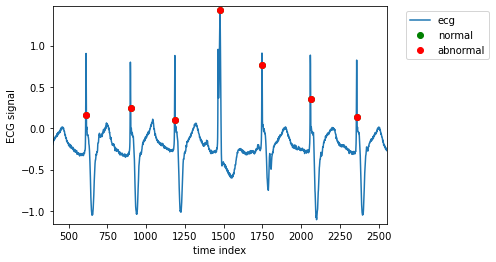

In [43]:
left = ab_index[5]-1080
right = ab_index[5]+1080

plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()

Make a dataset that is centered on beats with +- 3 seconds before and after.

In [44]:
def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    # input:
    # pts - list of patients
    # num_sec = number of seconds to include before and after the beat
    # fs = frequency
    # output: 
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)
    
    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    
    # list to keep track of number of beats across patients
    max_rows = []
    
    for pt in pts:
        file = DATA_PATH + pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
        # grab the first signal
        p_signal = p_signal[:,0]
        
        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal + ['N'])]
        
        X,Y,sym = build_XY(p_signal,df_ann, num_cols, abnormal)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]
    
    # check sizes make sense
    assert np.sum(max_rows) == X_all.shape[0], 'number of X, max_rows rows messed up'
    assert Y_all.shape[0] == X_all.shape[0], 'number of X, Y rows messed up'
    assert Y_all.shape[0] == len(sym_all), 'number of Y, sym rows messed up'

    return X_all, Y_all, sym_all



def build_XY(p_signal, df_ann, num_cols, abnormal):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y
    
    num_rows = len(df_ann)

    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1))
    sym = []
    
    # keep track of rows
    max_row = 0

    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in abnormal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X,Y,sym

In [45]:
num_sec = 3
fs = 360

In [46]:
abnormal

['L', 'R', 'V', '/', 'A', 'f', 'F', 'j', 'a', 'E', 'J', 'e', 'S']

In [ ]:
# import random
# random.seed( 42 )
# pts_train = random.sample(pts, 36)
# pts_valid = [pt for pt in pts if pt not in pts_train]
# print(len(pts_train), len(pts_valid))


# X_train, y_train, sym_train = make_dataset(pts_train, num_sec, fs, abnormal)
# X_valid, y_valid, sym_valid = make_dataset(pts_valid, num_sec, fs, abnormal)
# print(X_train.shape, y_train.shape, len(sym_train))
# print(X_valid.shape, y_valid.shape, len(sym_valid))

In [70]:
import random
random.seed(42)
pts_train = random.sample(pts, 28)

pts_dev = [pt for pt in pts if pt not in pts_train]

pts_val = random.sample(pts_dev, 10)
pts_test = [pt for pt in pts_dev if pt not in pts_val]

print(len(pts_train), len(pts_val), len(pts_test))

28 10 10


In [47]:
X_all, Y_all, sym_all = make_dataset(pts[:5], num_sec, fs, abnormal)
print(len(X_all))

10580


In [48]:
x_all = np.array(X_all)
y_all = np.array(Y_all)
sym_all = np.array(sym_all)

x_all.shape, y_all.shape, sym_all.shape

((10580, 2160), (10580, 1), (10580,))

In [49]:
np.savez(os.path.join(ROOT_DIR, "datasets", "raw_data.npz"), 
         name1=x_all, name2=y_all, name3=sym_all)

In [50]:
# Load data
data = np.load(os.path.join(ROOT_DIR, "datasets", "raw_data.npz"))
x_all = data['name1']
y_all = data['name2']
sym_all = data['name3']

In [51]:
x_all.shape, y_all.shape, sym_all.shape

((10580, 2160), (10580, 1), (10580,))

In [52]:
values, counts = np.unique(sym_all, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)

/ 3392
A 38
N 6421
V 7
f 722


In [53]:
sym_all

array(['N', 'N', 'N', ..., 'f', '/', '/'], dtype='<U1')

Shape of data:  (2160,) (2160,)


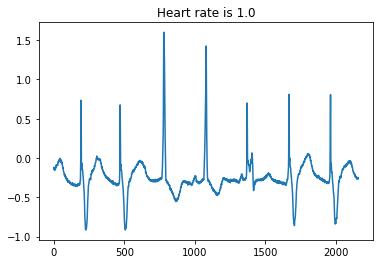

In [55]:
# Show data
count = 10000
x = x_all[count]
label = y_all[count][0]
y = np.array([i for i in range(len(x))])
print("Shape of data: ", x.shape, y.shape)
plt.title("Heart rate is {}".format(str(label)))
plt.plot(y, x)

In [52]:
# Dirs
normal = os.path.join(ROOT_DIR, "datasets", "full-heart-rate", "normal")
abnormal = os.path.join(ROOT_DIR, "datasets", "full-heart-rate", "abnormal")

os.makedirs(normal)
os.makedirs(abnormal)

#### Run this block on lab machine

In [ ]:
# Read heart rate
# Save image
# Read image and convert to grayscale and save again

count = 0
n_count, abn_count = 0, 0

temp_path = os.path.join(ROOT_DIR, "datasets", "full-heart-rate", "temp.png")
for x, y in zip(x_all, sym_all):
    
    plt.figure(frameon=False)
    plt.plot(x)
    plt.xticks([]), plt.yticks([])
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.tight_layout()
    plt.savefig(temp_path)
    plt.close()
                
    img = cv2.imread(temp_path, cv2.IMREAD_GRAYSCALE)
    
    if y is not "N":
        # Save in abnormal directory
        cv2.imwrite("{}/{}.png".format(abnormal, count), img)
        abn_count+=1
    else:
        # Save in normal directory
        cv2.imwrite("{}/{}.png".format(normal, count), img)   
        n_count+=1
    count+=1
                
print(abn_count, n_count)